# Stress Detection


### Importe de liberias

In [112]:
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import ParameterGrid
#from sklearn.model_selection import HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam




In [113]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [114]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
import xgboost as xgb 

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

### Lectura del dataset

In [116]:
df = pd.read_csv('https://raw.githubusercontent.com//valemicolgarcia//Stress-Detection//main//Stress.csv')
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [117]:
df.shape

(2838, 7)

### Columnas del dataset

- subreddit: comunidad o foro especifico
- post_id : identificador del post
- sentence_range: indice de oraciones
- text: texto usado para detectar estres
- label: 0 significa "sin estres" , 1 significa "estres"
- confidence: nivel de confianza de la persona en el texto
- social_timestamp: marca de tiempo que registra el post


### Distribución del numero de palabras

Text(0, 0.5, 'Frecuencia')

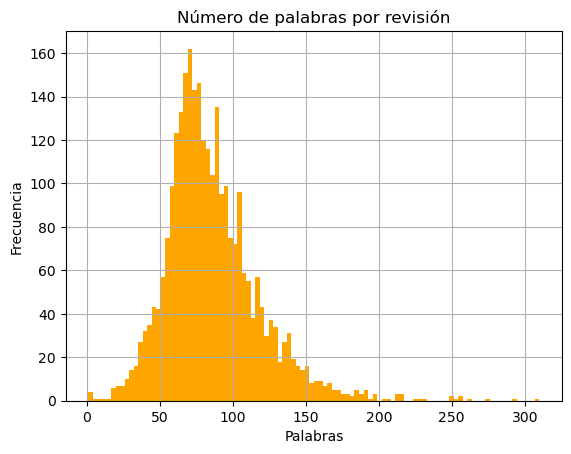

In [118]:
words_per_text = df['text'].apply(lambda x: len(x.split(" ")))
words_per_text.hist(bins = 100, color='orange')
plt.title('Número de palabras por revisión')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [119]:
words_per_text.mean()

85.84425651867512

### Distribución de los strings

In [120]:
df['label'].value_counts()

1    1488
0    1350
Name: label, dtype: int64

In [121]:
percent_val = 100 * df['label'].value_counts()/df.shape[0]
percent_val

1    52.43129
0    47.56871
Name: label, dtype: float64

Se observa que la distribucion de la variable a predecir es bastante pareja

Text(0, 0.5, 'Porcentaje (%)')

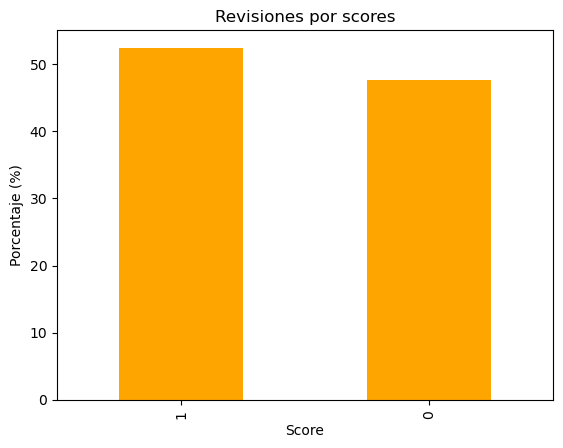

In [122]:
percent_val.plot.bar(color='orange')
plt.title('Revisiones por scores')
plt.xlabel('Score')
plt.ylabel('Porcentaje (%)')

# WordCloud general del dataset

1271414


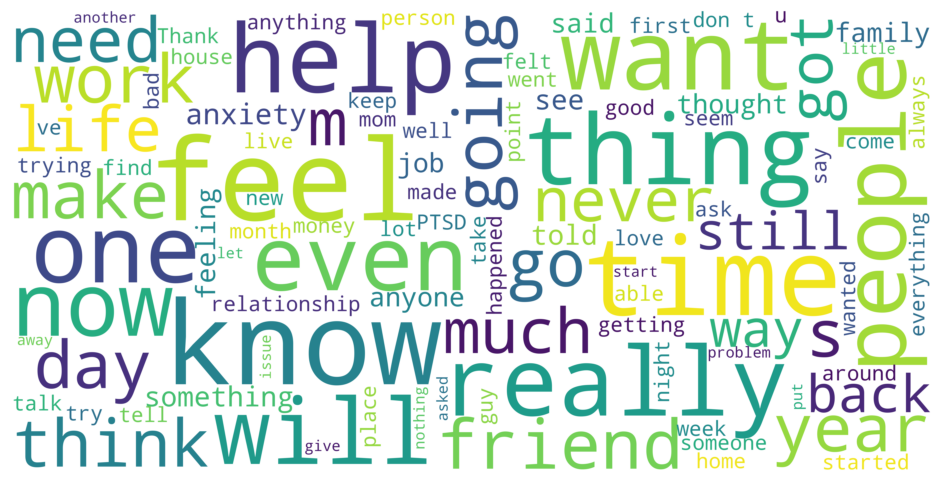

In [123]:
word_cloud_text = ''.join(df['text'])
print(len(word_cloud_text))

wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# WordCloud para personas estresadas

Length of text for target = 1: 685515


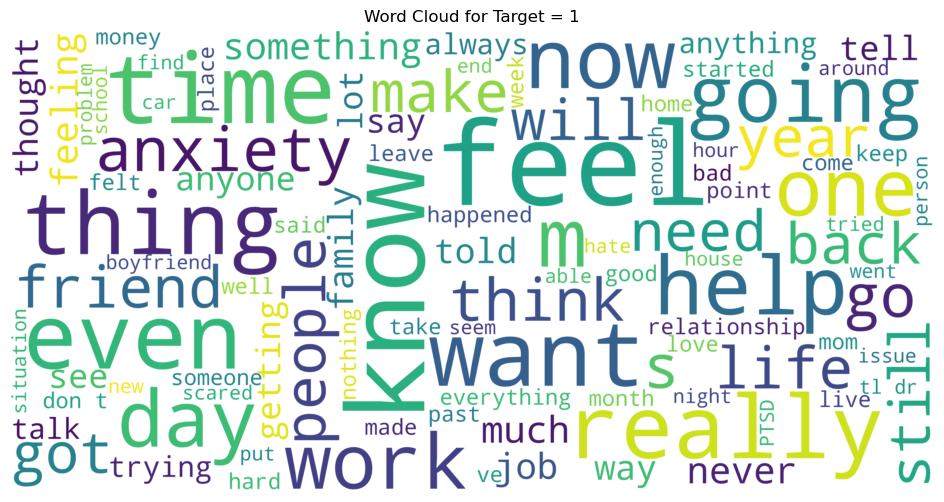

In [124]:
text_target_1 = ' '.join(df[df['label'] == 1]['text'])

print(f"Length of text for target = 1: {len(text_target_1)}")

wordcloud_1 = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(text_target_1)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for Target = 1')
plt.show()


Podemos ver que en las personas que se encuentran estresadas, las palabras mas comunes son "anxiety" , "friend", "work", "need", "back", "time", "know"

# WordCloud para personas no estresadas

Length of text for target = 0: 685515


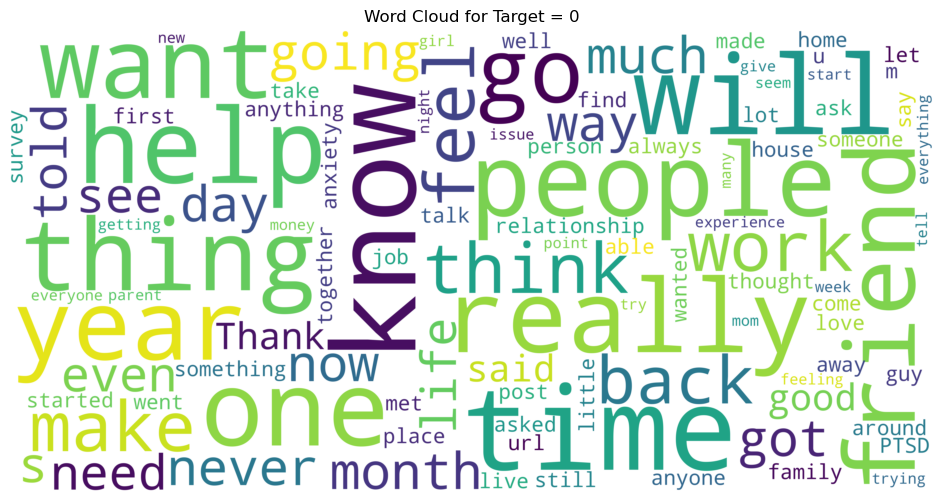

In [125]:
text_target_0 = ' '.join(df[df['label'] == 0]['text'])

print(f"Length of text for target = 0: {len(text_target_1)}")

wordcloud_1 = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="white",
    scale=10,
    width=800,
    height=400
).generate(text_target_0)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.title('Word Cloud for Target = 0')
plt.show()

Vemos que la palabra "friend" y "know" tambien son muy frecuentes en personas que no se encuentran estresadas.

# Procesamiento con NLTK

### Conversión de palabras a letras minúsculas

In [126]:
df['text_new'] = df['text'].apply(lambda x: x.lower())

### Eliminación de caracteres especiales

Remuevo los caracteres especiales

In [127]:
from nltk import word_tokenize
import nltk

nltk.download('punkt')

token_lists = [word_tokenize(each) for each in df['text']] #se convierte cada texto en una lista de palabras
tokens = [item for sublist in token_lists for item in sublist] #es una lista, donde cada sublista tiene los tokens de un post
print("Numero de tokens unicos antes: ", len(set(tokens))) #se eliminan duplicados con set

token_lists_lower = [word_tokenize(each) for each in df['text_new']] # se tokeniza de la misma forma la columna de text_new que tiene los posts en minusculas
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))

[nltk_data] Downloading package punkt to C:\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Numero de tokens unicos antes:  13888
Numero de tokens unicos nuevos:  12442


In [128]:
(12442 - 13888) / 13888

-0.10411866359447004

Se observa que el número de tokens bajó cerca del 10% con la normalización

In [129]:
# se seleccionan los caracteres no alfa numericos que no son espacios
special_chars = df['text_new'].apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# se obtiene una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'¯', "'", '‘', '%', '👩', '️', '\\', '"', '$', '\u200d', '–', '/', '€', '?', '.', '●', '^', '(', '”', '~', '<', '!', '😇', '·', '…', '\t', '➡', '💸', '´', '—', '&', '💕', '_', '🥕', '•', ';', '🐰', ']', '“', '😔', '£', '=', '-', '#', ')', '[', '🙂', '😦', '@', ':', '’', '>', '*', '+', '\u200e', '❤', ',', '🎓'}


Eliminación de caracteres especiales

In [130]:
import re
review_backup = df['text_new'].copy()
df['text_new'] = df['text_new'].apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)

Visualización de resultados al eliminar caracteres especiales

In [131]:
print("Review anterior:")
review_backup.values[0]

Review anterior:


'he said he had not felt that way before, suggeted i go rest and so ..trigger ahead if youi\'re a hypocondriac like me: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something i could even laugh at down the road. no, i ended up reading that this sense of doom can be indicative of various health ailments; one of which i am prone to.. so on top of my "doom" to my gloom..i am now f\'n worried about my heart. i do happen to have a physical in 48 hours.'

In [132]:
print("Review nuevo:")
df['text_new'][0]

Review nuevo:


'he said he had not felt that way before  suggeted i go rest and so  trigger ahead if youi re a hypocondriac like me  i decide to look up  feelings of doom  in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy  a stupid  are you psychic  test or new age b s  something i could even laugh at down the road  no  i ended up reading that this sense of doom can be indicative of various health ailments  one of which i am prone to  so on top of my  doom  to my gloom i am now f n worried about my heart  i do happen to have a physical in 48 hours '

Número de tokens eliminados

In [133]:
token_lists = [word_tokenize(each) for each in df['text']]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de token unicos antes: ", len(set(tokens)))

token_lists = [word_tokenize(each) for each in df['text_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos despues: ", len(set(tokens)))

Numero de token unicos antes:  13888
Numero de tokens unicos despues:  11529


# División en X e Y

In [134]:
X = df['text_new']
Y = df['label']

# Stemming y Lemantizacion

In [135]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# Inicializa el lemmatizer
lemmatizer = WordNetLemmatizer()

# Define la función de lemmatización
def lemmatize_text(text):
    words = word_tokenize(text)  # Tokeniza el texto en palabras
    lemmatized_words = [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]  # Aplica la lemmatización
    return ' '.join(lemmatized_words)  # Junta las palabras de nuevo en un solo texto

# Aplicar la función al DataFrame
X_lema = X.apply(lemmatize_text)


In [136]:
X_lema.head()

0    he say he have not felt that way before sugget...
1    hey there r assistance not sure if this be the...
2    my mom then hit me with the newspaper and it s...
3    until i meet my new boyfriend he be amaze he b...
4    october be domestic violence awareness month a...
Name: text_new, dtype: object

Al aplicar técnicas de stemming o lemantización se observa que las métricas bajan, por eso es que se toma la decisión de no aplicarlas para entrenar el modelo

# Eliminación de stopwords y palabras de alta frecuencia

### StopWords

In [137]:
import nltk
nltk.download('stopwords')

noise_words = []
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
noise_words.extend(eng_stop_words)
print(len(noise_words))
noise_words

179


[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Palabras de alta y baja frecuencia

 (1% de las palabras que aparecen con más frecuencia)

- Palabras de alta frecuencia

In [138]:
one_percentile = int(len(set(tokens)) * 0.01) #calcula el 1% de los tokens
top_1_percentile = Counter(tokens).most_common(one_percentile) #busca el 1% mas comun 
top_1_percentile[:10]

[('i', 13907),
 ('to', 8315),
 ('and', 7954),
 ('the', 6236),
 ('a', 5339),
 ('my', 4471),
 ('of', 3634),
 ('it', 3521),
 ('that', 3038),
 ('me', 3036)]

Text(0, 0.5, 'Frecuencia')

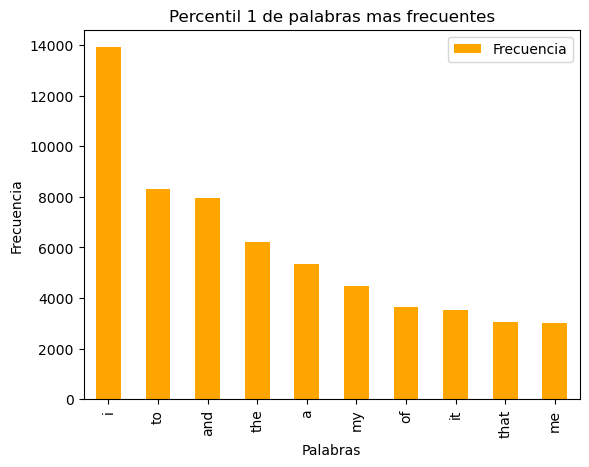

In [139]:
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar', color='orange')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

- Palabras de baja frecuencia

In [140]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
bottom_1_percentile[:10]

[('labyrinth', 1),
 ('bureaucracy', 1),
 ('squeeze', 1),
 ('wayne', 1),
 ('guzzler', 1),
 ('lightheadedness', 1),
 ('extremities', 1),
 ('radiates', 1),
 ('disassociation', 1),
 ('usd', 1)]

Se agregan las palabras de alta y baja frecuencia a la lista de las noise_words donde estaban las stop-words

In [141]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

# Vectorizacion (BOW)

Se tokenizan las noise words para evitar warnings y separar contracciones o frases en las stopwords

In [142]:
processed_stopwords = [word.lower() for stopword in noise_words for word in word_tokenize(stopword)]


### BOLSA DE PALABRAS - BAG OF WORDS

In [143]:
# Creacion de un objeto tipo CountVectorizer
bow_counts = CountVectorizer(
    tokenizer=word_tokenize, #tokenizador de nltk
    stop_words=processed_stopwords, #eliminamos stopwords y palabras de alta y baja frecuencia
    ngram_range=(1, 2) #bigramas
)

### División en datos de entrenamiento y de prueba

Dividimos en datos de entrenamiento y de prueba. Hacerlo antes de vectorizar sirve para poder compararlas mas facilmente con los textos originales, antes de que hayan sido preprocesadas y vectorizadas

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

In [145]:
X_train_bow = bow_counts.fit_transform(X_train) #fit_transform para vectorizar conjutno de entrenamiento
X_test_bow = bow_counts.transform(X_test) #transform vectorizar conjunto de prueba

In [146]:
len(bow_counts.get_feature_names_out()) + 1

73875

In [147]:
y_test.value_counts() / y_test.shape[0]

1    0.519366
0    0.480634
Name: label, dtype: float64

--------------------------------------------------

# Modelo de Regresión Logística

In [148]:
# modelo y entrenamiento
model = LogisticRegression(C=1, solver="lbfgs", max_iter=50000) 

model.fit(X_train_bow, y_train) #entrenamiento

# prediccion
test_pred_lr_prob = model.predict_proba(X_test_bow) 
test_pred_lr_all = model.predict(X_test_bow)


In [149]:
print("F1 score: ", f1_score(y_test, test_pred_lr_all))
print("Accuracy: ", accuracy_score(y_test, test_pred_lr_all) * 100)

F1 score:  0.7585034013605442
Accuracy:  75.0


### Validación cruzada

In [150]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Defino StratifiedKFold
skf = StratifiedKFold(n_splits=20, shuffle=True)

y_train_bow_array = np.array(y_train)

# Creación de listas para almacenar las métricas
accuracies = []
precisions = []
recalls = []
f1s = []

# Iteraciones sobre los splits de StratifiedKFold
for train_index, test_index in skf.split(X_train_bow, y_train_bow_array):
    
    X_train_vc, X_test_vc = X_train_bow[train_index], X_train_bow[test_index]
    y_train_vc, y_test_vc = y_train_bow_array[train_index], y_train_bow_array[test_index]

    # Entrenamiento del modelo
    model.fit(X_train_vc, y_train_vc)

    # Predicciones en el conjunto de prueba
    pred = model.predict(X_test_vc)

    # métricas
    accuracies.append(accuracy_score(y_test_vc, pred))
    precisions.append(precision_score(y_test_vc, pred, average='weighted'))
    recalls.append(recall_score(y_test_vc, pred, average='weighted'))
    f1s.append(f1_score(y_test_vc, pred, average='weighted'))

# Métricas promedio
print(f"Accuracy promedio (StratifiedKFold): {np.mean(accuracies):.2f}")
print(f"Precision promedio (StratifiedKFold): {np.mean(precisions):.2f}")
print(f"Recall promedio (StratifiedKFold): {np.mean(recalls):.2f}")
print(f"F1 Score promedio (StratifiedKFold): {np.mean(f1s):.2f}")


Accuracy promedio (StratifiedKFold): 0.70
Precision promedio (StratifiedKFold): 0.71
Recall promedio (StratifiedKFold): 0.70
F1 Score promedio (StratifiedKFold): 0.70


### Ajuste de hiperparámetros

In [151]:
params_grid = {
    'C': [1, 10, 100],  
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 500, 1000, 2000, 5000, 10000]  
    
}

halving_cv = HalvingGridSearchCV(model, params_grid, scoring="accuracy", factor=3)
halving_cv.fit(X_train_bow, y_train)

# Mejores parámetros y el mejor score de validación cruzada
print("Mejores parámetros:", halving_cv.best_params_)
print("Mejor Score CV:", halving_cv.best_score_)

# Rendimiento del modelo en el conjunto de prueba
y_test_pred = halving_cv.predict(X_test_bow)
accuracy_RL = accuracy_score(y_test, y_test_pred)
precision_RL = precision_score(y_test, y_test_pred, average='weighted')
recall_RL = recall_score(y_test, y_test_pred, average='weighted')
f1_RL = f1_score(y_test, y_test_pred, average='weighted')

# Métricas
print(' ')
print(f'Accuracy del modelo = {round(accuracy_RL, 5)}')
print(f'Precision del modelo = {round(precision_RL, 5)}')
print(f'Recall del modelo = {round(recall_RL, 5)}')
print(f'F1 Score del modelo = {round(f1_RL, 5)}')

import warnings
warnings.filterwarnings("ignore")
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Esto oculta los mensajes de TensorFlow
import warnings
from sklearn.exceptions import ConvergenceWarning
# Filtrar las advertencias de convergencia de Scikit-learn
warnings.filterwarnings("ignore", category=ConvergenceWarning)




Mejores parámetros: {'C': 1, 'max_iter': 100, 'solver': 'saga'}
Mejor Score CV: 0.7152317880794701
 
Accuracy del modelo = 0.74648
Precision del modelo = 0.74642
Recall del modelo = 0.74648
F1 Score del modelo = 0.74644


### Frecuencias

In [152]:
feature_names = np.array(bow_counts.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()
print('Coefs Stressed : \n{}'.format(feature_names[sorted_coef_index[:-21:-1]]))
print()
print('Coefs Not stressed :\n{}\n'.format(feature_names[sorted_coef_index[:20]]))

Coefs Stressed : 
['hate' 'scared' 'tell' 'stop' 'anxious' 'sick' 'days' 'terrified'
 'afraid' 'horrible' 'literally' 'boyfriend' 'crying' 'safe' 'hard'
 'almost' 'mentally' 'thinking' 'fucking' 'trying']

Coefs Not stressed :
['url' 'met' 'great' 'thank' 'older' 'first' '1' 'let' 'nice' 'way'
 'value' 'experience' 'helped' 'free' 'turned' 'bit' 'finally' 'edit'
 'share' 'etc']



Se puede observar que el modelo identificó con bastante claridad cuáles son las palabras más relacionadas con el estrés

### Wordclouds para analizar la explicabilidad del modelo

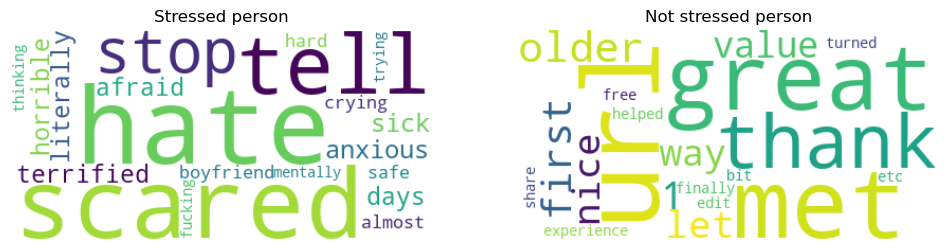

In [153]:
# palabras y coeficientes
feature_names = np.array(bow_counts.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()

# Palabras con coeficientes altos
top_words = feature_names[sorted_coef_index[:-40:-1]]
top_freqs = np.abs(model.coef_[0][sorted_coef_index[:-40:-1]])

# Palabras con coeficientes bajos
bottom_words = feature_names[sorted_coef_index[:40]]
bottom_freqs = np.abs(model.coef_[0][sorted_coef_index[:40]])

# diccionarios de frecuencias para WordCloud
top_word_freq = dict(zip(top_words, top_freqs))
bottom_word_freq = dict(zip(bottom_words, bottom_freqs))

plt.figure(figsize=(12, 6))

# Top coefficients
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(max_font_size=100, max_words=20, background_color="white").generate_from_frequencies(top_word_freq), interpolation="bilinear")
plt.axis("off")
plt.title("Stressed person")

# Bottom coefficients
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(max_font_size=100, max_words=20, background_color="white").generate_from_frequencies(bottom_word_freq), interpolation="bilinear")
plt.axis("off")
plt.title("Not stressed person")

plt.show()


### Prueba del modelo con Regresión Logística

In [154]:
def preprocess_text(text):
    text = text.lower()  # Convierto a minúsculas
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text) 
    return text

# Oración de prueba
prueba = 'I am really stressed and anxious'

# Preprocesar la oración
oracion_preprocessed = preprocess_text(prueba)

# transformo prueba a bag of words
prueba_bow = bow_counts.transform([oracion_preprocessed]) 

# prediccion
predictions = model.predict(prueba_bow)
prediction_binaria = predictions[0]  # `predictions` es una matriz, así que se toma el primer elemento

# Mostrar el resultado
print(f'La predicción para la oración "{prueba}" es: {prediction_binaria}')


La predicción para la oración "I am really stressed and anxious" es: 1


# XGBoost

In [155]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10,seed=42,max_depth=6, learning_rate=0.01)
clf_xgb.fit(X_train_bow,y_train) #Entrenamos el modelo


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [156]:
y_train_pred = clf_xgb.predict(X_train_bow) #Prediccion en Train
y_test_pred = clf_xgb.predict(X_test_bow) #Prediccion en Test

In [157]:
accuracy_XGB = accuracy_score(y_test, y_test_pred)
precision_XGB = precision_score(y_test, y_test_pred, average='weighted')
recall_XGB = recall_score(y_test, y_test_pred, average='weighted')
f1_XGB = f1_score(y_test, y_test_pred, average='weighted')

print(f'Precisión: {precision_XGB:.2f}')
print(f'Accuracy: {accuracy_XGB:.2f}')
print(f'Recall: {recall_XGB:.2f}')
print(f'F1 Score: {f1_XGB:.2f}')

Precisión: 0.63
Accuracy: 0.57
Recall: 0.57
F1 Score: 0.48


Las métricas son bastante bajas, por lo que se decide que el XGBoost no es el mejor modelo para resolver la detección de estrés

# Red Neuronal Densa

In [158]:
#defino el modelo
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_bow.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [159]:
history = model.fit(
    X_train_bow.toarray(),    # Datos de entrenamiento
    y_train,        # Etiquetas de entrenamiento
    epochs=15,      # Número de épocas (ajusta según sea necesario)
    batch_size=32,  # Tamaño del lote (ajusta según sea necesario)
    validation_split=0.2,  # Usa un 20% de los datos para validación
    verbose=1       # Para mostrar el progreso en la consola
)

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.5497 - loss: 0.6825 - val_accuracy: 0.7291 - val_loss: 0.6071
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8716 - loss: 0.3987 - val_accuracy: 0.7401 - val_loss: 0.5560
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9871 - loss: 0.0557 - val_accuracy: 0.7203 - val_loss: 0.6630
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9961 - loss: 0.0135 - val_accuracy: 0.7203 - val_loss: 0.7175
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9997 - loss: 0.0057 - val_accuracy: 0.7203 - val_loss: 0.7424
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9947 - loss: 0.0234 - val_accuracy: 0.7203 - val_loss: 0.7496
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9960 - loss: 0.0106 - val_accuracy: 0.7225 - val_loss: 0.7568
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.7269 - v

In [160]:
test_loss, test_acc = model.evaluate(X_test_bow, y_test)
print(f"Test Accuracy: {test_acc}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7374 - loss: 0.7565
Test Accuracy: 0.73591548204422


Se puede observar que el accuracy de la red neuronal no es mejor que la del modelo de regresión lineal

In [161]:
predictions = model.predict(X_test_bow)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


### Prueba del modelo

In [162]:
prueba = 'I am really anxious because i have lots of things to do'

def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales
    return text

oracion_preprocessed = preprocess_text(prueba)
prueba_bow = bow_counts.transform([oracion_preprocessed])

prueba_bow_dense = prueba_bow.toarray() # Mantener como sparse matrix

# Hacer predicción con el modelo
predictions = model.predict(prueba_bow_dense)


prediction_binaria = (predictions >= 0.5).astype(int)
prediction_binaria[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1

# Modelo LSTM

A continuacion se trabajará con LSTM (Long Short Term Memory), un tipo de red neuronal recurrente (RNN) diseñada para aprender y recordar dependencias a largo plazo en secuencias de datos
- En el contexto de las redes neuronales recurrentes como LSTM el uso de bag of words ignora el orden y la estructyra gramatical de las palabras, no captura las relaciones contextuales ni las dependencias entre palabras, ya que cada palabra se trata de manera aislada. 
- Por eso es que se evita la transformacion a BOW en este modelo

### Eliminación de stopwords


In [163]:
def remove_noise(text, noisewords):
    tokens = word_tokenize(text.lower())
    cleaned_text = [word for word in tokens if word not in noisewords]
    return ' '.join(cleaned_text)

X_train_clean = X_train.apply(lambda x: remove_noise(x, noise_words))
X_test_clean = X_test.apply(lambda x: remove_noise(x, noise_words))


In [164]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_clean)

# Convertimos los textos a secuencias
train_sequences = tokenizer.texts_to_sequences(X_train_clean)
test_sequences = tokenizer.texts_to_sequences(X_test_clean)

# Padding para tener secuencias de la misma longitud
X_train_padded = pad_sequences(train_sequences, maxlen=100)
X_test_padded = pad_sequences(test_sequences, maxlen=100)


### Modelo LSTM

In [165]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=256, input_length=100))
model.add(LSTM(units=256, return_sequences=False))

model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento
model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5816 - loss: 0.7098 - val_accuracy: 0.6567 - val_loss: 0.6198
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.8694 - loss: 0.3411 - val_accuracy: 0.6813 - val_loss: 0.7436
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9550 - loss: 0.1397 - val_accuracy: 0.6655 - val_loss: 0.9652
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9881 - loss: 0.0435 - val_accuracy: 0.6602 - val_loss: 1.3389
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9908 - loss: 0.0287 - val_accuracy: 0.6989 - val_loss: 1.3887
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9981 - loss: 0.0100 - val_accuracy: 0.6954 - val_loss: 1.4981
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.9980 - loss: 0.0051 - val_accuracy: 0.6919 - val_loss: 1.6987
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.9988 - loss: 0.0070 - val_accuracy: 0

In [166]:
# Evaluación en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_padded, y_test)

print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6879 - loss: 1.4821
Pérdida en el conjunto de prueba: 1.5669573545455933
Precisión en el conjunto de prueba: 0.6795774698257446


In [167]:
prueba = 'I am really stressed and anxious and sad'
prueba_wn = remove_noise(prueba, noise_words)
# oración en secuencia de números
oracion_sequence = tokenizer.texts_to_sequences([prueba_wn])
# padding para que tenga la misma longitud
oracion_padded = pad_sequences(oracion_sequence, maxlen=100)

prediction = model.predict(oracion_padded)

#prediccion
predicted_label = 1 if prediction[0][0] > 0.5 else 0  # Accede al valor del array

print(f'Predicción: {predicted_label}')  # 1 = estresado, 0 = no estresado


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Predicción: 1
